# Create necessary framework

## Create the necessary training data 

In [2]:
library(tidyverse)
library(car)
library(olsrr)
library(stringr)
library(tidytext)
library(syuzhet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘car’ was built under R version 3.4.4”Loading required package: carData
Warning message:
“package ‘carData’ was built under R version 3.4.4”
Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘olsrr’

The following object is masked from ‘package:datasets’:

    rivers

Warning message:
“package ‘tidytext’ was built under R version 

In [3]:
# Make sure to change this
setwd("/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Text Analytics Project")

" 
Read in the CSV file
"
personality = as.tibble(read.csv("youtube-personality/YouTube-Personality-Personality_impression_scores_train.csv", 
                                 encoding = "UTF-8",
                                 sep = " "))

gender = as.tibble(read.csv("youtube-personality/YouTube-Personality-gender.csv",
                            encoding = "UTF-8",
                            sep = " "))

audiovisual = as.tibble(read.csv("youtube-personality/YouTube-Personality-audiovisual_features.csv",
                                 encoding = "UTF-8",
                                 sep = " "))

transcripts = as.tibble(read.csv("youtube-personality/transcripts.csv",
                                 encoding = "UTF-8",
                                 sep = ","))

transcripts$index = as.character(transcripts$index)

transcripts =
  transcripts %>%
  rename(vlogId = index,
         transcript = X0) %>%
  mutate(vlogId = substr(vlogId, 1, nchar(vlogId)-4))

personality$vlogId = as.character(personality$vlogId)
gender$vlogId = as.character(gender$vlogId)
audiovisual$vlogId = as.character(audiovisual$vlogId)

training_data = 
  personality %>%
  left_join(gender, on = c("vlogID" = "vlogID")) %>%
  left_join(audiovisual, on = c("vlogID" = "vlogID")) %>%
  left_join(transcripts, on = c("clogID" = "vlogID"))

#tokenization
training_data$transcript <- as.vector(training_data$transcript)
tidy_data <- training_data %>% 
  unnest_tokens(word, transcript, to_lower = TRUE) %>% 
  anti_join(get_stopwords())

#count the total number of words for each person
total_words <- tidy_data %>% 
  group_by(vlogId) %>% 
  count() %>% 
  rename(total_words = n)

#count the percentage of words related to big 5
words_E = c("bar","drinks", "restaurant", "dancing", "restaurants", "grandfather", "miami", "countless", "drinking", "shots", "girls", "glorious", "pool", "crowd", "sang", "grilled")
words_A = c("wonderful", "together", "visiting", "morning", "spring", "walked", "beautiful", "staying", "felt", "share", "gray", "joy", "afternoon", "day", "moments", "hug", "glad")
words_C = c("completed", "adventure", "adventures", "enjoying", "hawaii", "it's", "deck")
words_N = c("awful", "though", "lazy", "worse", "depressing", "irony", "terrible", "stressful", "horrible", "sort", "annoying", "ashamed", "ban")
words_O = c("folk", "humans", "of", "poet", "art", "by", "universe", "poetry", "narrative", "culture", "century", "sexual", "films", "novel", "decades", "ink", "passage", "literature", "blues")
words_nE = c("other", "cats", "computer", "minor")
words_nA = c("porn", "cost", "fuck")
words_nC = c("stupid", "boring", "desperate", "saying", "utter", "it's", "extreme")
words_nN = c("road", "southern", "visited", "ground", "oldest", "invited", "completed")
words_nO = c("giveaway")

check_words <- function(wordlist){
  tidy_data %>% 
    filter(word %in% wordlist) %>% 
    group_by(vlogId) %>% 
    count() %>% 
    left_join(total_words) %>% 
    mutate(n/total_words) %>% 
    select(-n, -total_words)
}

E_words <- check_words(words_E) %>% 
  rename(words_Extraversion = 'n/total_words')

A_words <- check_words(words_A) %>% 
  rename(words_Agreeableness = 'n/total_words')

C_words <- check_words(words_C) %>% 
  rename(words_Conscientiousness = 'n/total_words')

N_words <- check_words(words_N) %>% 
  rename(words_Neuroticism = 'n/total_words')

O_words <- check_words(words_O) %>% 
  rename(words_Openness = 'n/total_words')

nE_words <- check_words(words_nE) %>% 
  rename(words_nExtraversion = 'n/total_words')

nA_words <- check_words(words_nA) %>% 
  rename(words_nAgreeableness = 'n/total_words')

nC_words <- check_words(words_nC) %>% 
  rename(words_nConscientiousness = 'n/total_words')

nN_words <- check_words(words_nN) %>% 
  rename(words_nNeuroticism = 'n/total_words')

nO_words <- check_words(words_nO) %>% 
  rename(words_nOpenness = 'n/total_words')

#putting them bag to the training data
training_data <- training_data %>% 
  left_join(E_words) %>%
  left_join(A_words) %>%
  left_join(C_words) %>%
  left_join(N_words) %>%
  left_join(O_words) %>%
  left_join(nE_words) %>%
  left_join(nA_words) %>%
  left_join(nC_words) %>%
  left_join(nN_words) %>%
  left_join(nO_words) %>% 
  replace(., is.na(.), 0)

#sentiment analysis with nrc
nrc <- tidy_data %>% 
  inner_join(get_sentiments('nrc')) %>%
  count(`vlogId`, sentiment) %>%
  spread(sentiment, n, fill = 0)

training_data <- training_data %>% 
  left_join(nrc) %>%
  left_join(total_words) %>%
  mutate(anger = anger / total_words,
         anticipation = anticipation / total_words,
         disgust = disgust / total_words,
         fear = fear / total_words,
         joy = joy / total_words,
         negative = negative / total_words,
         positive = positive / total_words,
         sadness = sadness / total_words,
         surprise = surprise / total_words,
         trust = trust / total_words) %>%
  select(-total_words)

# sentiment scores from syuzhet package - positive = positive emotions, 
# negative = negative emotions
training_data$sentiment <- get_sentiment(
    as.vector(training_data$transcript), method = "afinn")

training_data = 
    training_data %>%
    select(-transcript)

[1] " \nRead in the CSV file\n"

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"


## Standardise the data

In [6]:
temp1 = 
    training_data %>%
    select(-vlogId, - gender,
           - Extr:-Open) %>%
    scale()

training_data = 
    training_data %>%
    select(vlogId, gender,
           Extr:Open) %>%
    cbind(temp1)

# Modelling Openness

## Baseline model 

In the baseline model, all the features are included.

In [15]:
training_data = training_data[,c(2,7,8:53)]

In [19]:
baseline = lm(Open ~ ., data = training_data)

In [20]:
summary(baseline)


Call:
lm(formula = Open ~ ., data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.82533 -0.43860 -0.02886  0.45276  1.63781 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.528055   0.068775  65.838   <2e-16 ***
genderMale                0.286063   0.118120   2.422   0.0161 *  
mean.pitch                0.003226   0.073332   0.044   0.9649    
sd.pitch                 -0.081317   0.073678  -1.104   0.2707    
mean.conf.pitch          -0.036171   0.126209  -0.287   0.7746    
sd.conf.pitch             0.066180   0.079691   0.830   0.4070    
mean.spec.entropy        -0.014193   0.119011  -0.119   0.9052    
sd.spec.entropy          -0.050946   0.072217  -0.705   0.4811    
mean.val.apeak            0.050985   0.087887   0.580   0.5623    
sd.val.apeak              0.118271   0.069695   1.697   0.0908 .  
mean.loc.apeak            0.179671   0.098335   1.827   0.0688 .  
sd.loc.apeak             

Warning message:
“not plotting observations with leverage one:
  28”Warning message:
“not plotting observations with leverage one:
  28”

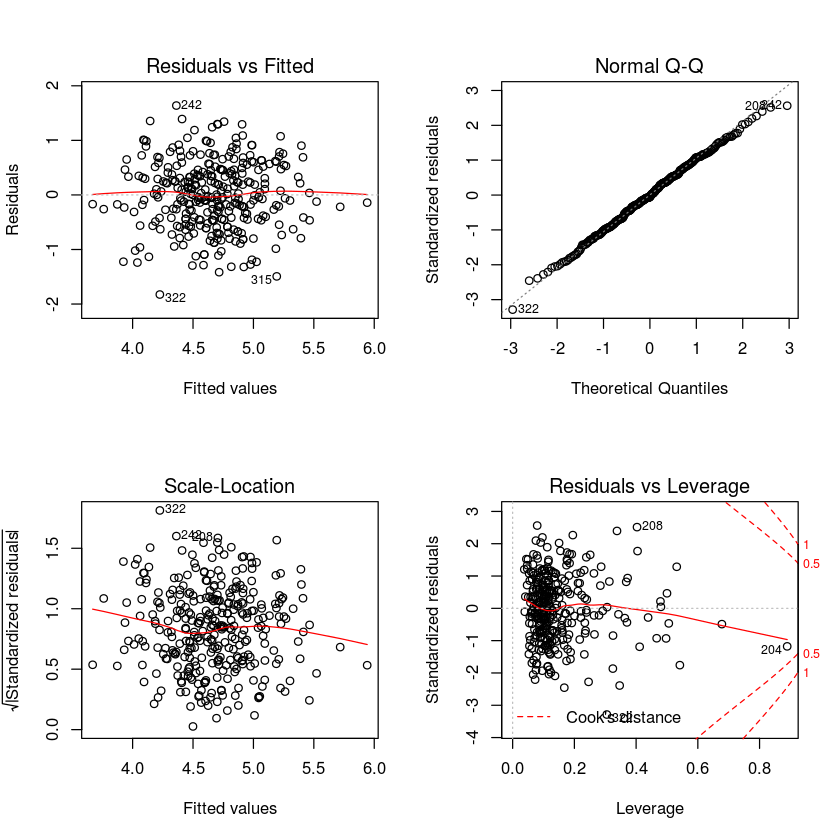

In [22]:
par(mfrow = c(2,2))
plot(baseline)

In [23]:
vif(baseline)[vif(baseline) > 10]

mean.conf.pitch mean.spec.entropy    mean.num.apeak    avg.voiced.seg 
         11.59118          10.30668          11.74448          11.60390

**Adjusted R-squared:** 0.1184. 

It may be a good idea to remove multi-collinear variables before backward selection (based on a p-threshold of < 0.3) as multicollinear variables may lead to inflated p-values.

Here, multicollinear variables are identified as those having a VIF > 10. Those variables are:

- mean.conf.pitch
- mean.spec.entropy
- mean.num.apeak
- avg.voiced.seg

## Model 2
In model 2, we try to reduce multicollinearity as a precursor the backward selection. We do this by removing certain features.

In [24]:
model2 = update(baseline, ~. 
                -mean.spec.entropy 
                -mean.num.apeak 
                -mean.conf.pitch)

We removed **mean.spec.entropy**, **mean.num.apeak**, and **mean.conf.pitch**. Now, no variables have a VIF of higher than 10.

In [28]:
summary(model2)


Call:
lm(formula = Open ~ gender + mean.pitch + sd.pitch + sd.conf.pitch + 
    sd.spec.entropy + mean.val.apeak + sd.val.apeak + mean.loc.apeak + 
    sd.loc.apeak + sd.num.apeak + mean.energy + sd.energy + mean.d.energy + 
    sd.d.energy + avg.voiced.seg + avg.len.seg + time.speaking + 
    voice.rate + num.turns + hogv.entropy + hogv.median + hogv.cogR + 
    hogv.cogC + words_Extraversion + words_Agreeableness + words_Conscientiousness + 
    words_Neuroticism + words_Openness + words_nExtraversion + 
    words_nAgreeableness + words_nConscientiousness + words_nNeuroticism + 
    words_nOpenness + anger + anticipation + disgust + fear + 
    joy + negative + positive + sadness + surprise + trust + 
    sentiment, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.74828 -0.43536  0.00562  0.43486  1.62882 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.535778   0.068112  66.593   <2e-16 

## Model 3
In model 3, we integrate **backward selection** by removing features with p-values higher than 0.3.

In [45]:
to_remove = ols_step_backward(model2, prem = 0.3)

We are eliminating variables based on p value...
No more variables satisfy the condition of prem: 0.3


In [46]:
paste(to_remove$removed, collapse = " - ")

[1] "words_nExtraversion - joy - mean.pitch - sd.energy - words_Conscientiousness - fear - anticipation - disgust - sd.spec.entropy - mean.val.apeak - hogv.entropy - mean.d.energy - hogv.cogR - words_Agreeableness - voice.rate - sd.loc.apeak - surprise - words_Neuroticism - words_Openness - words_Extraversion - avg.voiced.seg"

Features above were removed.

In [47]:
model3 = update(model2, ~. - words_nExtraversion - joy - mean.pitch - sd.energy - words_Conscientiousness 
                           - fear - anticipation - disgust - sd.spec.entropy - mean.val.apeak - hogv.entropy 
                           - mean.d.energy - hogv.cogR - words_Agreeableness - voice.rate - sd.loc.apeak 
                           - surprise - words_Neuroticism - words_Openness - words_Extraversion - avg.voiced.seg)

In [48]:
summary(model3)


Call:
lm(formula = Open ~ gender + sd.pitch + sd.conf.pitch + sd.val.apeak + 
    mean.loc.apeak + sd.num.apeak + mean.energy + sd.d.energy + 
    avg.len.seg + time.speaking + num.turns + hogv.median + hogv.cogC + 
    words_nAgreeableness + words_nConscientiousness + words_nNeuroticism + 
    words_nOpenness + anger + negative + positive + sadness + 
    trust + sentiment, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.88303 -0.45295 -0.00438  0.45507  1.67094 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.54509    0.06153  73.862  < 2e-16 ***
genderMale                0.25134    0.10167   2.472   0.0140 *  
sd.pitch                 -0.10860    0.05521  -1.967   0.0501 .  
sd.conf.pitch             0.05712    0.05183   1.102   0.2713    
sd.val.apeak              0.07429    0.04357   1.705   0.0892 .  
mean.loc.apeak            0.09536    0.06378   1.495   0.1360    
sd.num.apeak      

## Model 4
Remove rows where absolute studentized residual exceeded 3 and where there were high leverage points.

In [127]:
outlierTest(model3)

No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferonni p
322 -3.051862          0.0024784      0.80053

In [50]:
training_data = training_data[-322,]

In [53]:
model4 = update(model2, ~. - words_nExtraversion - joy - mean.pitch - sd.energy - words_Conscientiousness 
                           - fear - anticipation - disgust - sd.spec.entropy - mean.val.apeak - hogv.entropy 
                           - mean.d.energy - hogv.cogR - words_Agreeableness - voice.rate - sd.loc.apeak 
                           - surprise - words_Neuroticism - words_Openness - words_Extraversion - avg.voiced.seg)

In [57]:
summary(model4)


Call:
lm(formula = Open ~ gender + sd.pitch + sd.conf.pitch + sd.val.apeak + 
    mean.loc.apeak + sd.num.apeak + mean.energy + sd.d.energy + 
    avg.len.seg + time.speaking + num.turns + hogv.median + hogv.cogC + 
    words_nAgreeableness + words_nConscientiousness + words_nNeuroticism + 
    words_nOpenness + anger + negative + positive + sadness + 
    trust + sentiment, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5075 -0.4332  0.0000  0.4361  1.6863 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.54080    0.06072  74.788  < 2e-16 ***
genderMale                0.27282    0.10054   2.714  0.00704 ** 
sd.pitch                 -0.11776    0.05455  -2.159  0.03166 *  
sd.conf.pitch             0.05043    0.05117   0.986  0.32513    
sd.val.apeak              0.06022    0.04322   1.393  0.16457    
mean.loc.apeak            0.09594    0.06292   1.525  0.12836    
sd.num.apeak             -0.

## Model 5
Modelling non-linear relationships.

#### Scatterplots give indications of non-linear relationships between Openness and the features.

In [59]:
training_data = 
    training_data %>%
    select(Open, gender, sd.pitch,
           sd.conf.pitch, sd.val.apeak,
           mean.loc.apeak, sd.num.apeak,
           mean.energy, sd.d.energy,
           avg.len.seg, time.speaking,
           num.turns,hogv.median,
           hogv.cogC, words_nAgreeableness,
           words_nConscientiousness,words_nNeuroticism,
           words_nOpenness, anger,
           negative, positive,
           sadness, trust, sentiment)

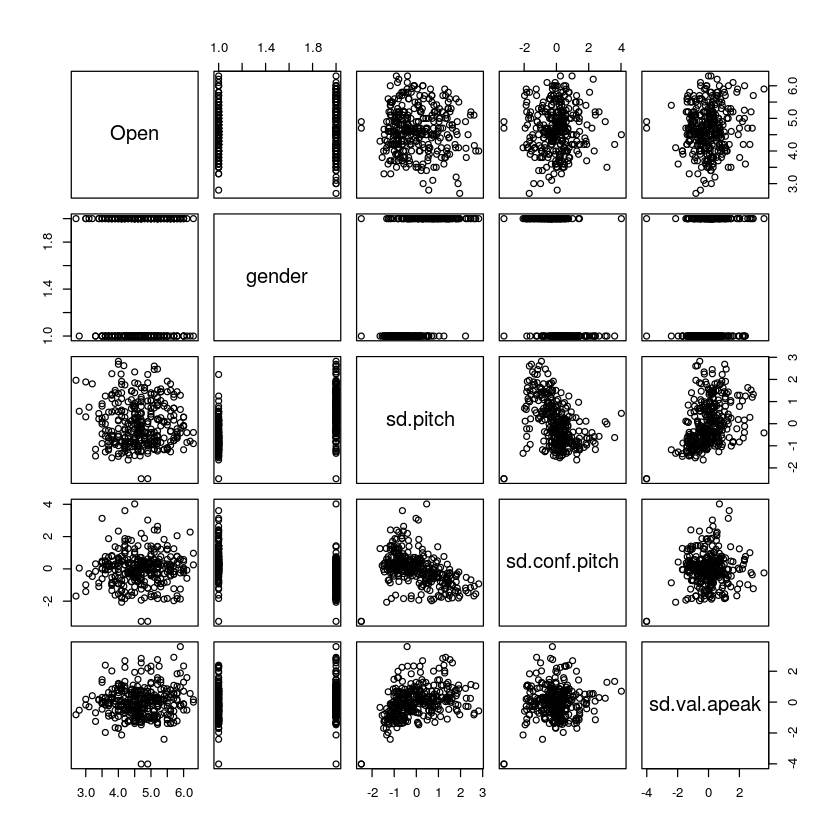

In [61]:
pairs(training_data[,c(1:5)])

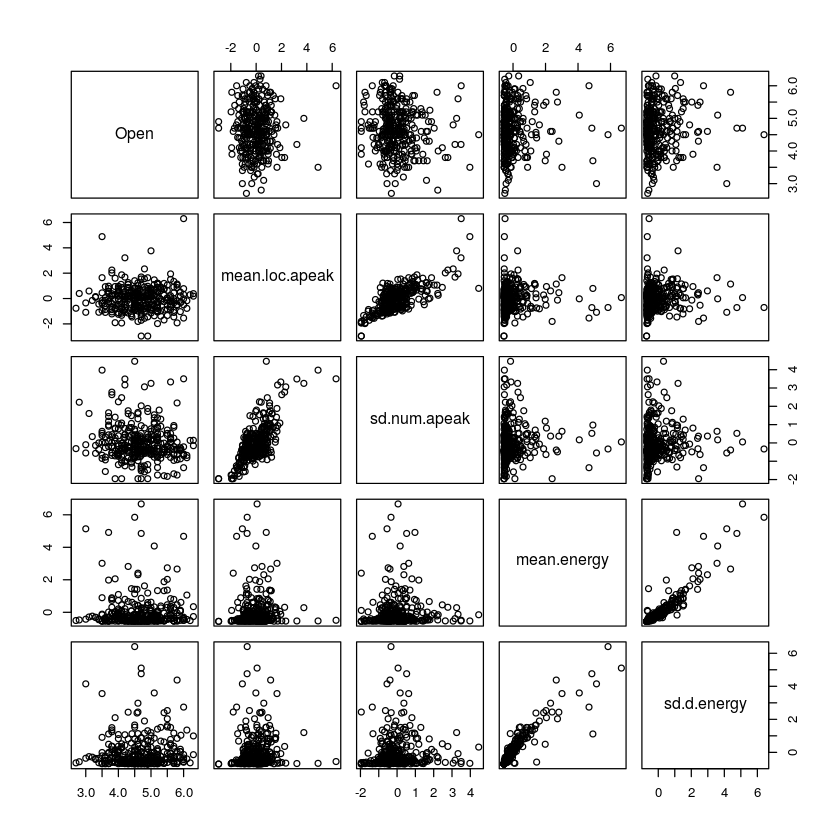

In [62]:
pairs(training_data[,c(1, 6:9)])

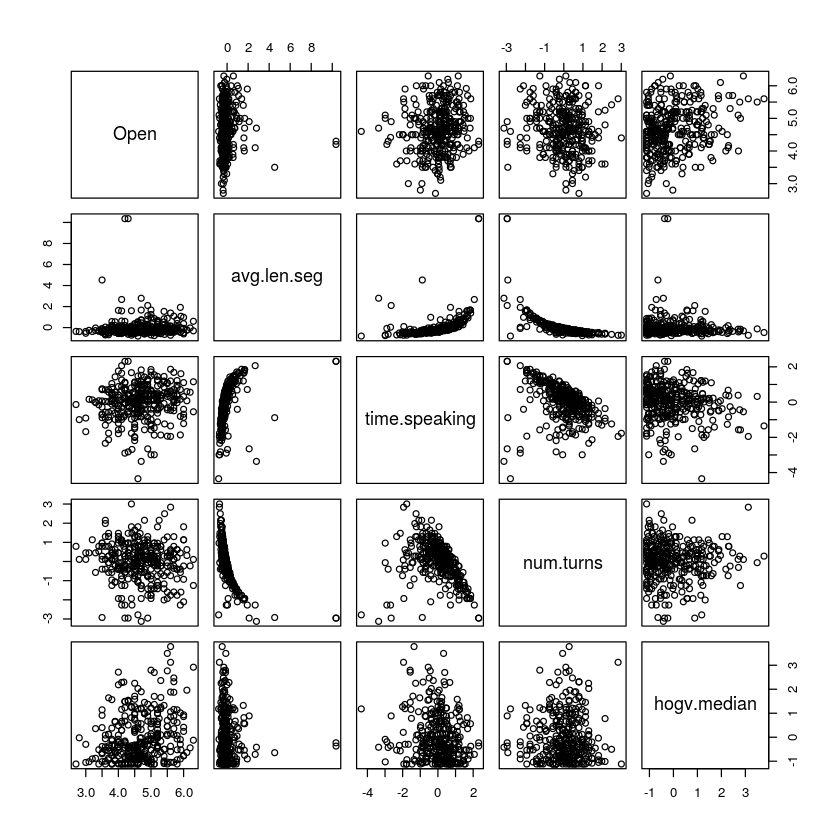

In [63]:
pairs(training_data[,c(1, 10:13)])

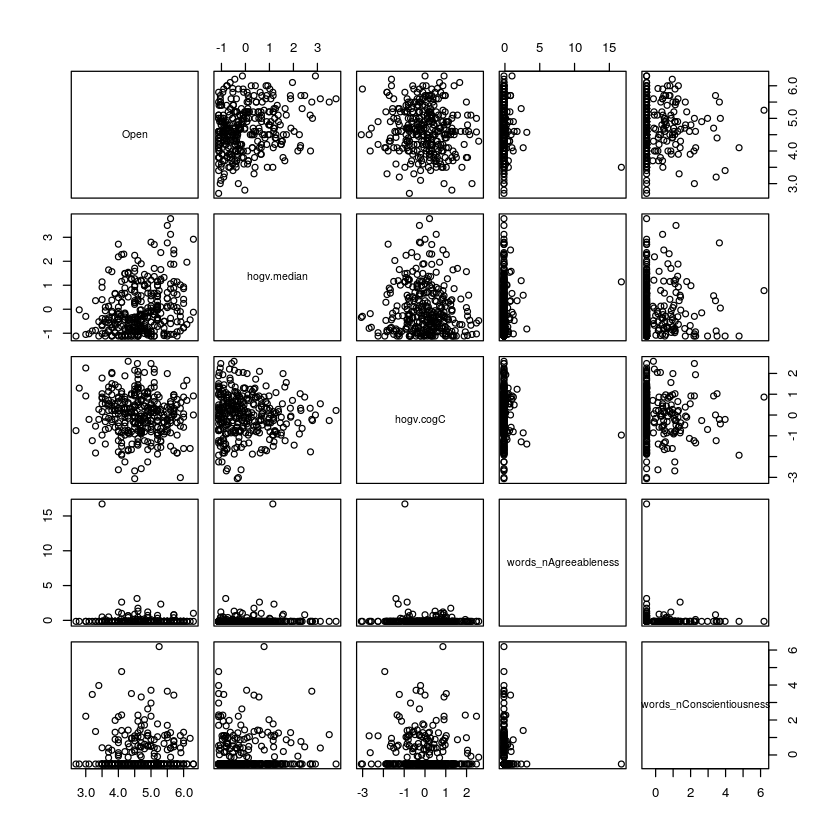

In [64]:
pairs(training_data[,c(1, 13:16)])

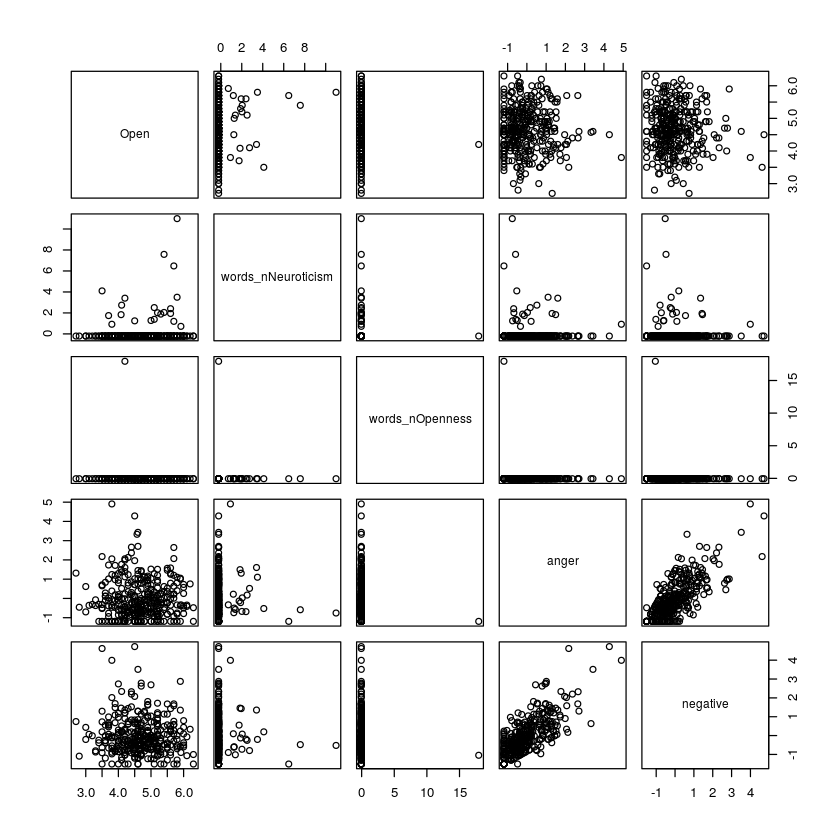

In [65]:
pairs(training_data[,c(1, 17:20)])

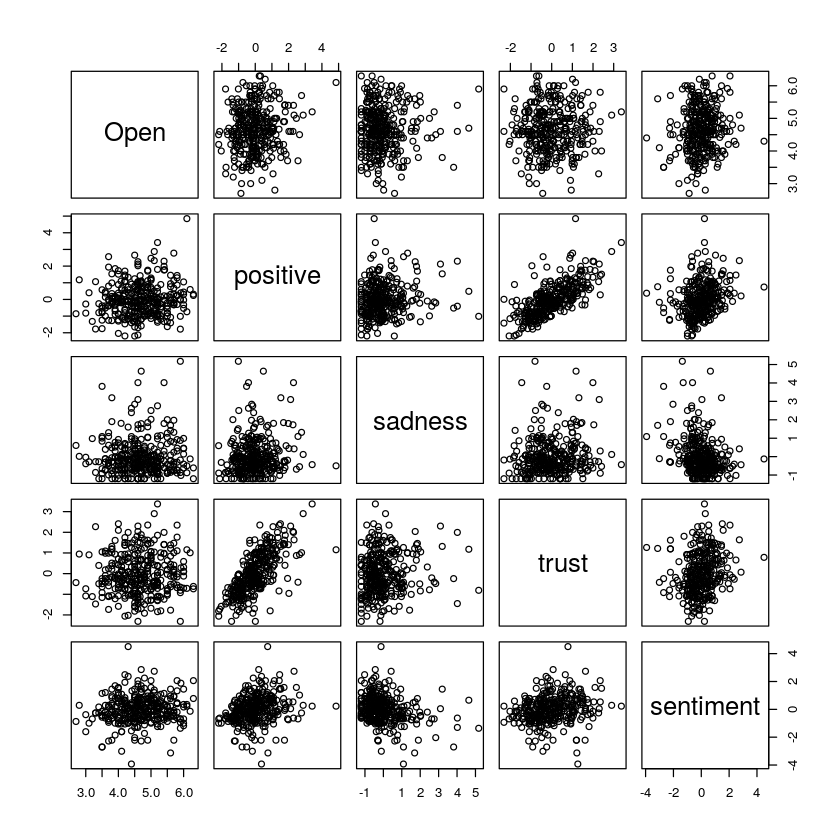

In [66]:
pairs(training_data[,c(1, 21:24)])

No non-linear relationships detected.

## Model 6
Modeling interactions with gender. 

In [108]:
model6 = update(model4, ~. + gender*words_nConscientiousness)
summary(model6)


Call:
lm(formula = Open ~ gender + sd.pitch + sd.conf.pitch + sd.val.apeak + 
    mean.loc.apeak + sd.num.apeak + mean.energy + sd.d.energy + 
    avg.len.seg + time.speaking + num.turns + hogv.median + hogv.cogC + 
    words_nAgreeableness + words_nConscientiousness + words_nNeuroticism + 
    words_nOpenness + anger + negative + positive + sadness + 
    trust + sentiment + gender:words_nConscientiousness, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6648 -0.3908  0.0131  0.4211  1.5738 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          4.56116    0.06036  75.566  < 2e-16 ***
genderMale                           0.26190    0.09935   2.636 0.008826 ** 
sd.pitch                            -0.11325    0.05389  -2.102 0.036433 *  
sd.conf.pitch                        0.04121    0.05063   0.814 0.416378    
sd.val.apeak                         0.05829    0.04269   1.365 0.17316

Warning message:
“not plotting observations with leverage one:
  28”Warning message:
“not plotting observations with leverage one:
  28”

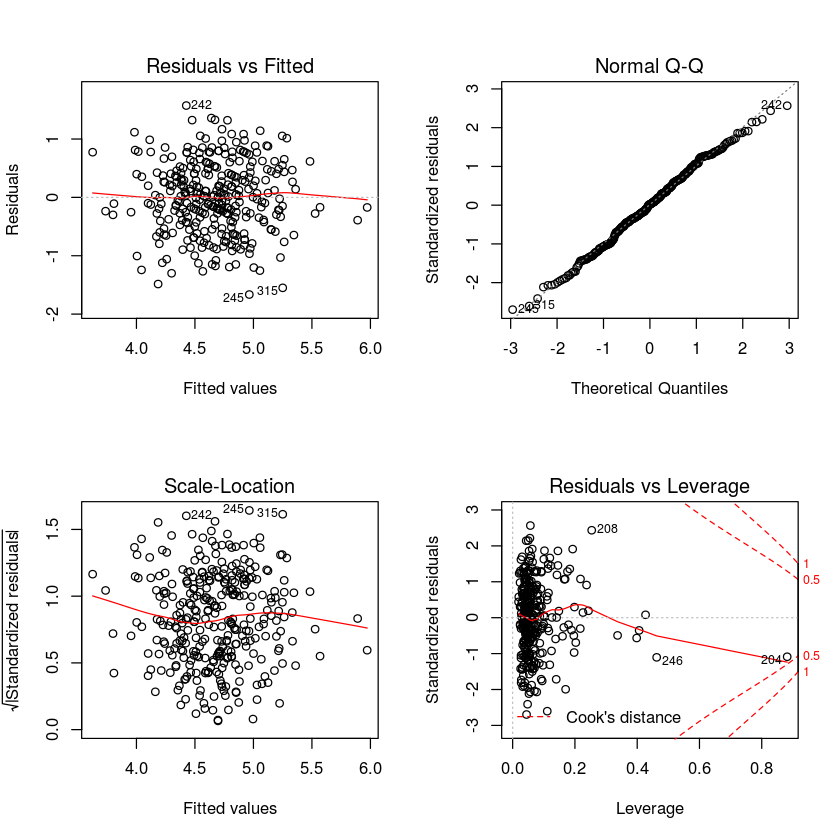

In [110]:
par(mfrow = c(2,2))
plot(model6)